# Assignment 1 Cars Dataset 


### Getting our workspace ready

Let's import all the necessary libraries and set our current working directory to a variable

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import torch
from torchvision import models, datasets
import torch.nn as nn
import scipy.io
from PIL import Image
from sklearn.model_selection import train_test_split
import requests
import xtarfile as tarfile

curr_dir = os.getcwd()

## Task 1: Build a function that converts a labelled dataset into labelled and unlabelled subsets.

My function takes a pd.Series object that has class labels as data and corresponding dataset index as its index
It then samples 1 instance from each of the classes and then samples rest of the instances randomly from the remaining instances

The function return two lists, one containing indices that are supposed to be labelled and nother containing indices that are supposed to be unlabelled

In [2]:
def split_series_min_1(dataset_labels, proportion):
    label_count = int(len(dataset_labels) * (1-proportion))
    df = pd.DataFrame(dataset_labels)
    sample = df.groupby(by='class_idx').sample(1)
    sample = sample.append(
        df[~df.index.isin(sample.index)] # only rows that have not been selected
        .sample(n=label_count-sample.shape[0]) # sample more rows as needed
    ).sort_index()
    label_indices = sample.index
    unlable_indices = df[~df.index.isin(sample.index)].index
    return list(label_indices), list(unlable_indices)
    

### Load Data
I downloaded the data from the provided link https://ai.stanford.edu/~jkrause/cars/car_dataset.html
The devkit folder has a file cars_train_annos.mat that has class indices mapped to the corresponding images and cars_meta.mat file has the list of all indices

I will create a DataFrame called data_set that will contain all the detailes about the image files

Below cell downloads training dataset tar file to data folder of the working directory and unzips it

the devkit folder is already in the repository

In [3]:
url = "http://ai.stanford.edu/~jkrause/car196/cars_train.tgz"
r = requests.get(url)
open(curr_dir + "/data/cars_train.tgz", "wb").write(r.content)
# unzip training folder
with tarfile.open(curr_dir + "/data/cars_train.tgz", 'r:gz') as archive:
    archive.extractall(curr_dir + "/data")

In [4]:
#using loadmat() funtion of scipy.io to read matlab binary files
cars_meta = scipy.io.loadmat(curr_dir + '/data/devkit/cars_meta.mat') 
class_names = pd.Series([str(name[0]) for name in cars_meta['class_names'][0]], name="class_name")
class_names.index+=1
cars_train_annos = scipy.io.loadmat(curr_dir + '/data/devkit/cars_train_annos.mat')

In [5]:
class_labels = pd.Series(
    [int(class_label[0]) for class_label in cars_train_annos['annotations']['class'][0]],
    name='class_idx'
)
file_names = pd.Series(
    [str(file_name[0]) for file_name in cars_train_annos['annotations']['fname'][0]],
    name='file_name'
)

In [6]:
data_set = pd.concat([pd.Series(file_names.index), file_names], axis=1)
data_set = data_set.rename(columns={0:'data_set_idx'})
data_set['file_path'] = [curr_dir + "/data/cars_train/" + fname for fname in data_set['file_name']]
data_set = pd.concat([data_set, class_labels], axis=1)
data_set = data_set.merge(class_names, left_on='class_idx', right_on= class_names.index, how='left')

In [7]:
data_set

,data_set_idx,file_name,file_path,class_idx,class_name
0,0,00001.jpg,/Users/viv/my_data/work/statistics_canada/data...,14,Audi TTS Coupe 2012
1,1,00002.jpg,/Users/viv/my_data/work/statistics_canada/data...,3,Acura TL Sedan 2012
2,2,00003.jpg,/Users/viv/my_data/work/statistics_canada/data...,91,Dodge Dakota Club Cab 2007
3,3,00004.jpg,/Users/viv/my_data/work/statistics_canada/data...,134,Hyundai Sonata Hybrid Sedan 2012
4,4,00005.jpg,/Users/viv/my_data/work/statistics_canada/data...,106,Ford F-450 Super Duty Crew Cab 2012
...,...,...,...,...,...
8139,8139,08140.jpg,/Users/viv/my_data/work/statistics_canada/data...,78,Chrysler Town and Country Minivan 2012
8140,8140,08141.jpg,/Users/viv/my_data/work/statistics_canada/data...,196,smart fortwo Convertible 2012
8141,8141,08142.jpg,/Users/viv/my_data/work/statistics_canada/data...,163,Mercedes-Benz SL-Class Coupe 2009
8142,8142,08143.jpg,/Users/viv/my_data/work/statistics_canada/data...,112,Ford GT Coupe 2006


In [103]:
data_set.class_name.value_counts()

GMC Savana Van 2012                                    68
Chrysler 300 SRT-8 2010                                49
Mercedes-Benz 300-Class Convertible 1993               48
Mitsubishi Lancer Sedan 2012                           48
Jaguar XK XKR 2012                                     47
                                                       ..
Rolls-Royce Phantom Drophead Coupe Convertible 2012    31
Chevrolet Express Cargo Van 2007                       30
Maybach Landaulet Convertible 2012                     29
FIAT 500 Abarth 2012                                   28
Hyundai Accent Sedan 2012                              24
Name: class_name, Length: 196, dtype: int64

In [8]:
# Function to get image as numpy array using file_path
def get_image_from_path(file_path):
    image = imread(file_path)
    return image

Bentley Continental GT Coupe 2007


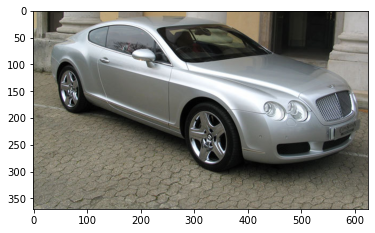

In [9]:
# Looking at a random image and its class
plt.imshow(get_image_from_path(data_set['file_path'][1000]))
print(data_set['class_name'][1000])

## Task 2: Data cleaning

In [10]:
# function to check if the image located at the given path is 3-channel or not
def check_RGB(file_path):
    try:
        image = imread(file_path) # read in an image
        if image.ndim != 3:
            return False
        else:
            return True
    except:
        return False

In [11]:
%%time
# initiate a new column in data_set with a is_RGB flag
# this cell might take a bit to run
data_set['is_RGB'] = data_set['file_path'].map(lambda file_path: check_RGB(file_path))

CPU times: user 1min 31s, sys: 25.9 s, total: 1min 57s
Wall time: 2min 26s


In [12]:
# function to delete file at the mentioned file_path
def delete_files(file_paths):
    for file_path in file_paths:
        try:
            os.remove(file_path)
        except:
            continue

In [13]:
# function to delete all non-RGB images from the disk
def delete_non_RGB_images(file_paths, folder_name):
    count1 = 0
    for path in os.listdir(curr_dir + "/data/" + folder_name):
        # check if current path is a file
        if os.path.isfile(os.path.join(curr_dir + "/data/" + folder_name, path)):
            count1 += 1
    print('File count before deletion:', count1)

    delete_files(file_paths)
    
    count2 = 0
    for path in os.listdir(curr_dir + "/data/" + folder_name):
        # check if current path is a file
        if os.path.isfile(os.path.join(curr_dir + "/data/" + folder_name, path)):
            count2 += 1
    print('File count after deletion:', count2)
    if count1 == count2:
        return "Failed"
    else: 
        return "Success"

In [14]:
delete_status = delete_non_RGB_images(data_set[data_set['is_RGB']==False].file_path, "cars_train")
data_set = data_set.loc[data_set.is_RGB==True]

File count before deletion: 8144
File count after deletion: 8126


## Task 3: Dataset representation

1. Load pretrained resnet18 model
2. Replace the fully connected final layer with identity layer
3. Create transformer to preprocess images
4. Create function to forward pass one image at a time and return embeddings
5. Save embeddings to disk

In [15]:
# loading a pretrained resnet18 model
model = models.resnet18(pretrained=True)

# replacing the mmodel.fc layer with Identity layer with 512 out_features
model.fc = nn.Identity()

/Users/viv/.conda/envs/glue/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/Users/viv/.conda/envs/glue/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Transformer to preprocess images
from torchvision import transforms
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

There's scope for enhancements in the above transformer, but for now we will go with a simple one

In [17]:
#function to forward pass one image at a time and return embeddings in the specified format
def get_resnet18_output(data_set, model, transforms):
    embeddings_dict = dict()
    for index, row in data_set.iterrows():
        img = Image.open(row['file_path']) 
        img_tensor = transforms(img).reshape((1,3,224,224))
        resnet18_output = model(img_tensor).reshape(512)
        dict_ele = {
            "embedding": resnet18_output.detach().numpy(),
            "class_idx": row['class_idx'],
            "labelled": True
        }
        embeddings_dict[index] = dict_ele
    return embeddings_dict

In [18]:
%%time
# running the function with our data_set
embeddings_dict = get_resnet18_output(data_set, model, transforms)

CPU times: user 16min 22s, sys: 2min 52s, total: 19min 14s
Wall time: 18min 25s


In [19]:
# saving our dict
torch.save(embeddings_dict, curr_dir + '/embeddings_dict.pt')

In [20]:
# loading our dict
embeddings_dict = torch.load(curr_dir + '/embeddings_dict.pt')

In [21]:
embeddings_dict[0]

{'embedding': array([0.94455284, 0.9368853 , 0.9504109 , 1.0915345 , 0.91757256,
        0.89275825, 0.92629516, 1.064274  , 0.88701576, 0.92185915,
        0.91651696, 0.89591575, 0.90016717, 0.881884  , 0.8382377 ,
        0.9297963 , 0.96670735, 1.3530878 , 0.9501871 , 0.85147715,
        0.94308734, 1.1296682 , 0.95373285, 1.0304201 , 0.88473874,
        0.988906  , 0.8953928 , 0.9569432 , 0.8901322 , 0.89232093,
        0.94572264, 0.9279541 , 0.9844675 , 0.85562956, 0.8952065 ,
        0.87990934, 0.98419046, 1.0078696 , 0.89535797, 0.8996763 ,
        0.8802657 , 0.9049912 , 0.82883716, 0.99400485, 0.80796874,
        0.9435906 , 0.9500127 , 1.1704112 , 0.89932275, 0.9097659 ,
        0.97892076, 0.9807114 , 0.79764104, 0.9432918 , 0.83657116,
        0.9611002 , 1.0467632 , 0.9673366 , 1.034347  , 0.99136156,
        0.92958087, 0.9038848 , 0.9797889 , 0.9322253 , 0.8975569 ,
        1.0036563 , 0.8586741 , 1.0134481 , 1.0142994 , 0.83465326,
        0.9084855 , 0.8652187 , 0.8

## Task 4: Build a partially labelled dataset

I created a function that takes in the embeddings_dict that we have finalized and a proportion and splits it into two groups using the function split_series_min_1 created above

In [22]:
def unlable_dataset(embeddings_dict, proportion):
    dataset_labels = pd.Series([
    values['class_idx'] for values in embeddings_dict.values()], 
    index=embeddings_dict.keys(), name='class_idx'
    )

    label_indices, unlable_indices = split_series_min_1(dataset_labels, proportion)
    
    for i in unlable_indices:
        embeddings_dict[i]['labelled'] = False
    for i in label_indices:
        embeddings_dict[i]['labelled'] = True
    
    return embeddings_dict

In [23]:
# running the function on our dataset and saving the result into dataset_dict_main to be used in all the further steps
dataset_dict_main = unlable_dataset(embeddings_dict, 0.60)

In [24]:
len(dataset_dict_main)

8126

## Task 5: Create train/validation split

1. Get embeddings from the final dataset and push into list X
2. Get class idices and push into list y
3. Split X and Y in the proportion passed as an argument

In [25]:
def custom_train_test_split(data_set_inputs, data_set_labels, training_proportion):
    X_train, X_test, y_train, y_test = train_test_split(data_set_inputs,
                                                        data_set_labels, 
                                                        test_size=1-training_proportion,
                                                        random_state=42)
    print("train test split")
    print(len(X_train), len(y_train), len(X_test), len(y_test))
    return X_train, y_train, X_test, y_test

In [26]:
X = [values['embedding'] for values in dataset_dict_main.values() if values['labelled'] == True]
y = [values['class_idx'] for values in dataset_dict_main.values() if values['labelled'] == True]

training_inputs, training_labels, test_inputs, test_labels = custom_train_test_split(X, y, .80)

train test split
2600 2600 650 650


## Task 6: Create experiment(s) to convince clients that more labelled data will improve model performance

1. Run SGD Classifier with default parameters
2. Split dataset into different proportions and check accuracy score
3. Plot the improvement

In [27]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, loss='modified_huber'))
model.fit(training_inputs, training_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(loss='modified_huber'))])

There's a lot of scope for enhancing the above model through hyperparameter tuning

In [28]:
model.score(test_inputs, test_labels)

0.02923076923076923

In [29]:
accuracies = []
for i in [.40, .50, .60, .70]:
    # using our custom_train_test_split function
    training_inputs, training_labels, test_inputs, test_labels = custom_train_test_split(X, y, i)
    model.fit(training_inputs, training_labels)
    accuracies.append((i, model.score(test_inputs, test_labels)))


train test split
1300 1300 1950 1950
train test split
1625 1625 1625 1625
train test split
1950 1950 1300 1300
train test split
2274 2274 976 976


### As can be seen from the graph below, the more labelled data we have the better accuracy we get

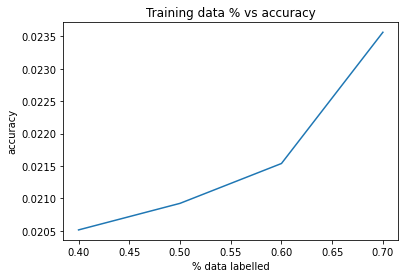

In [30]:
x_axis = [i[0] for i in accuracies]
y_axis = [i[1] for i in accuracies]
fig = plt.figure()
ax = plt.axes()
ax.plot(x_axis, y_axis)
ax.set(xlabel='% data labelled', ylabel='accuracy', title='Training data % vs accuracy');

## Task 7: Active learning to select new instances to be labelled

1. Train our model using all of the labelled data
2. For all the unlabelled data find entropy using scipy.stats 
3. Find no. of images needed to take the labelled dataset to 65% of total data
4. Get K highest entropy images and retrieve lables using our dictionary
5. Relable images using reusable function

In [31]:
# create function to relable data that can be used repetively 
def relable_dataset(embeddings_dict, X, y, model_all, proportion):
    # fitting model to all of our data
    model_all.fit(X, y)
    y_unlabelled_entropy = []
    for key, value in embeddings_dict.items():
        if value['labelled'] == False:
            predict_prob = model_all.predict_proba(value['embedding'].reshape(1,-1))
            entropy_dict = {
                'data_label_idx': key,
                'entropy': float(entropy(predict_prob, axis=1))
            }
            y_unlabelled_entropy.append(entropy_dict)                                         

    entropy_df = pd.DataFrame(y_unlabelled_entropy)
    entropy_df = entropy_df.sort_values('entropy', ascending=False)
    
    # get the no. of images needed to take the labelled dataset to 65% of total data
    K = int(len(embeddings_dict) * proportion - len(X))

    # set K highest entropy labelled flag to True
    for i in entropy_df[:K].data_label_idx:
        embeddings_dict[i]['labelled'] = True
    return embeddings_dict

In [32]:
from scipy.stats import entropy

model_all = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, loss='modified_huber'))

# relable to 65% of the data
dataset_dict_main = relable_dataset(dataset_dict_main, X, y, model_all, 0.65)

## Task 8: Final model training and evaluation

1. Create new train test datasets using our previously created function custom_train_test_split
2. train the model 
3. evaluate on test dataset

In [33]:
# getting new train and test inputs all of which are labelled
X = [values['embedding'] for values in dataset_dict_main.values() if values['labelled'] == True]
y = [values['class_idx'] for values in dataset_dict_main.values() if values['labelled'] == True]

training_inputs, training_labels, test_inputs, test_labels = custom_train_test_split(X, y, .80)

train test split
4224 4224 1057 1057


In [34]:
# Creating final model
model_final = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, loss='modified_huber', penalty='l2'))

model_final.fit(training_inputs, training_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(loss='modified_huber'))])

In [35]:
# Scoring the final model
model_final.score(test_inputs, test_labels)

0.03122043519394513

In [37]:
# saving and loading the model
torch.save(model_final, curr_dir + "/data/model_final.pt")

loaded_final_model = torch.load(curr_dir + "/data/model_final.pt")

## Conclusion

1. Even though overall accuracies are small we do see a slight improvement with expanding the labelled dataset 0.03 vs 0.031
2. The decision to label more data was not really fruitful in increasing accuracy
3. Final performance: 3.12% accuracy
